### Feature Extraction Using STFT

In [3]:
import pandas as pd
import numpy as np
import librosa
import glob
import os

def window_signal(df, window_size, window_step):
    windows = []
    time_metadata = []
    for start in range(0, len(df), window_step):
        end = start + window_size
        if end > len(df):
            # Pad the signal if it's shorter than the window size
            window = np.pad(df.iloc[start:]['beam [Pa]'].values, (0, end - len(df)), 'constant')
        else:
            window = df.iloc[start:end]['beam [Pa]'].values
        windows.append(window)

        # Record start and end times
        start_time = df.index[start]
        end_time = df.index[min(end - 1, len(df) - 1)]
        time_metadata.append((start_time, end_time))

    return windows, time_metadata


def apply_stft_and_save(signal_windows, time_metadata, output_dir, n_fft=254, hop_length=96, base_name='signal'):
    all_magnitudes = []  # List to store all magnitudes for global normalization

    # Step 1: Initial STFT computation
    for window in signal_windows:
        Zxx = librosa.stft(window, n_fft=n_fft, hop_length=hop_length)
        Zxx_magnitude = np.abs(Zxx)
        all_magnitudes.append(Zxx_magnitude)

    # Step 2: Global Min-Max normalization
    global_min = min(mag.min() for mag in all_magnitudes)
    global_max = max(mag.max() for mag in all_magnitudes)

    def normalize(magnitude):
        return (magnitude - global_min) / (global_max - global_min)

    metadata = []
    for i, (window, (start_time, end_time)) in enumerate(zip(all_magnitudes, time_metadata)):
        normalized_window = normalize(window)

        # Print the shape of the STFT magnitude
        print(f"Shape of window {i}: {normalized_window.shape}")

        output_file_path = os.path.join(output_dir, f"{base_name}_window_{i}.npy")
        np.save(output_file_path, normalized_window[..., np.newaxis])  # Saving with shape (x, y, 1)

        metadata.append({
            'window_index': i,
            'start_time': str(start_time),
            'end_time': str(end_time),
            'file_path': output_file_path,
        })

    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(os.path.join(output_dir, f"{base_name}_metadata.csv"), index=False)
    



DB Scaling Test

In [6]:
import pandas as pd
import numpy as np
import torch
import glob
import os
import sympy

def segmenting(df, window_size, window_step):
    windows = []
    time_metadata = []
    for start in range(0, len(df), window_step):
        end = start + window_size
        if end <= len(df):
            window = df.iloc[start:end]['beam [Pa]'].values

            # Normalize the window using librosa
            normalized_window = librosa.util.normalize(window)

            windows.append(normalized_window)
            start_time = df.index[start]
            end_time = df.index[end - 1]
            time_metadata.append((start_time, end_time))
    return windows, time_metadata

def apply_stft_and_save(signal_windows, time_metadata, output_dir, n_fft=254, hop_length=96, base_name='signal'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    metadata = []
    for i, (window, (start_time, end_time)) in enumerate(zip(signal_windows, time_metadata)):
        # Apply STFT using librosa
        Zxx = librosa.stft(window, n_fft=n_fft, hop_length=hop_length)

        # Convert magnitude to dB scale using librosa
        Zxx_db = librosa.amplitude_to_db(np.abs(Zxx), ref=np.max)[..., np.newaxis]  # Add a new axis

        # Save the dB-scaled spectrogram
        output_file_path = os.path.join(output_dir, f"{base_name}_window_{i}.npy")
        np.save(output_file_path, Zxx_db)

        metadata.append({
            'window_index': i,
            'start_time': str(start_time),
            'end_time': str(end_time),
            'file_path': output_file_path,
        })

    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(os.path.join(output_dir, f"{base_name}_metadata.csv"), index=False)

In [7]:
folder_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/COMBINED'
output_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/NORMALIZED'
window_size = 3000  # Fixed window size
window_step = 1500  # Window step

for csv_file in glob.glob(os.path.join(folder_path, '*.csv')):
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    signal_windows, time_metadata = segmenting(df, window_size, window_step)
    base_name = os.path.splitext(os.path.basename(csv_file))[0]
    apply_stft_and_save(signal_windows, time_metadata, output_dir, n_fft=254, hop_length=96, base_name=base_name)

In [8]:
data = np.load('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/NORMALIZED/2018-06-24_22-50-00_window_0.npy')
print(data.shape)

(128, 32, 1)


Scipy Normalization test

In [7]:
import os
import numpy as np
from scipy.signal import stft
import pandas as pd

def apply_stft_and_save(input_folder, output_dir, nperseg=256, noverlap=128, base_name='signal'):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    metadata = []
    file_list = os.listdir(input_folder)
    
    for i, file_name in enumerate(file_list):
        if file_name.endswith('.npy'):
            # Load the segmented waveform from the .npy file
            window = np.load(os.path.join(input_folder, file_name))

            # Compute STFT using scipy.signal.stft
            _, _, Zxx = stft(window, nperseg=nperseg, noverlap=noverlap)
            Zxx_magnitude = np.abs(Zxx)[..., np.newaxis]  # Keep dimensions consistent

            # Print the shape of Zxx_magnitude
            print(f"Shape of window {i}: {Zxx_magnitude.shape}")

            # Save the STFT magnitude to a file
            output_file_path = os.path.join(output_dir, f"{base_name}_window_{i}.npy")
            np.save(output_file_path, Zxx_magnitude)

            # Append metadata for the current window
            metadata.append({
                'window_index': i,
                'file_name': file_name,
                'file_path': output_file_path,
            })

    # Save metadata to a CSV file
    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(os.path.join(output_dir, f"{base_name}_metadata.csv"), index=False)

# Example usage
input_folder = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/SEGMENTED_DATASET'  # Update with your folder path
output_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/SCIPY_N'  # Update with your desired output path
nperseg = 254
noverlap = 92

apply_stft_and_save(input_folder, output_dir, nperseg=nperseg, noverlap=noverlap, base_name='stft_result')


Shape of window 0: (128, 20, 1)
Shape of window 1: (128, 20, 1)
Shape of window 2: (128, 20, 1)
Shape of window 3: (128, 20, 1)
Shape of window 4: (128, 20, 1)
Shape of window 5: (128, 20, 1)
Shape of window 6: (128, 20, 1)
Shape of window 7: (128, 20, 1)
Shape of window 8: (128, 20, 1)
Shape of window 9: (128, 20, 1)
Shape of window 10: (128, 20, 1)
Shape of window 11: (128, 20, 1)
Shape of window 12: (128, 20, 1)
Shape of window 13: (128, 20, 1)
Shape of window 14: (128, 20, 1)
Shape of window 15: (128, 20, 1)
Shape of window 16: (128, 20, 1)
Shape of window 17: (128, 20, 1)
Shape of window 18: (128, 20, 1)
Shape of window 19: (128, 20, 1)
Shape of window 20: (128, 20, 1)
Shape of window 21: (128, 20, 1)
Shape of window 22: (128, 20, 1)
Shape of window 23: (128, 20, 1)
Shape of window 24: (128, 20, 1)
Shape of window 25: (128, 20, 1)
Shape of window 26: (128, 20, 1)
Shape of window 27: (128, 20, 1)
Shape of window 28: (128, 20, 1)
Shape of window 29: (128, 20, 1)
Shape of window 30: 

Shape of window 400: (128, 20, 1)
Shape of window 401: (128, 20, 1)
Shape of window 402: (128, 20, 1)
Shape of window 403: (128, 20, 1)
Shape of window 404: (128, 20, 1)
Shape of window 405: (128, 20, 1)
Shape of window 406: (128, 20, 1)
Shape of window 407: (128, 20, 1)
Shape of window 408: (128, 20, 1)
Shape of window 409: (128, 20, 1)
Shape of window 410: (128, 20, 1)
Shape of window 411: (128, 20, 1)
Shape of window 412: (128, 20, 1)
Shape of window 413: (128, 20, 1)
Shape of window 414: (128, 20, 1)
Shape of window 415: (128, 20, 1)
Shape of window 416: (128, 20, 1)
Shape of window 417: (128, 20, 1)
Shape of window 418: (128, 20, 1)
Shape of window 419: (128, 20, 1)
Shape of window 420: (128, 20, 1)
Shape of window 421: (128, 20, 1)
Shape of window 422: (128, 20, 1)
Shape of window 423: (128, 20, 1)
Shape of window 424: (128, 20, 1)
Shape of window 425: (128, 20, 1)
Shape of window 426: (128, 20, 1)
Shape of window 427: (128, 20, 1)
Shape of window 428: (128, 20, 1)
Shape of windo

In [3]:
import numpy as np
from scipy.signal import stft

segment_length = 3000  # Length of each segment
desired_num_freq_bins = 128
desired_num_time_bins = 32

# Set the window size to match the segment length
nperseg = segment_length

# Calculate the overlap (noverlap) and hop_length based on desired shape
noverlap = (nperseg - desired_num_time_bins)
hop_length = (segment_length - noverlap) // (desired_num_time_bins - 1)

# Example: Apply STFT to a segment
segment = np.random.randn(segment_length)  # Replace with your actual segment data
frequencies, times, Zxx = stft(segment, nperseg=nperseg, noverlap=noverlap)

print("Spectrogram shape:", Zxx.shape)


Spectrogram shape: (1501, 25)


In [59]:
data = np.load('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/SEGMENTED_DATASET/2018-06-24_22-50-00_window_0.npy')
print(data.shape)

(3000,)


In [63]:
data = np.load('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/COMBINE_STFT/2018-06-24_22-50-00_window_0.npy')
print(data.shape)

(128, 32, 1)


In [64]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import glob

def load_and_stack_npy(directory):
    files = glob.glob(f'{directory}/*.npy')
    sorted_files = sorted(files, key=lambda x: x.split('/')[-1])
    data_arrays = [np.load(file) for file in sorted_files]
    return np.stack(data_arrays)

# Directory containing your .npy files
data_directory = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/SCIPY_N'  # Replace with your directory path

# Load data
data = load_and_stack_npy(data_directory)

np.save('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/train_test_N_SCIPY.npy', data)

In [3]:
import pandas as pd
import numpy as np
import librosa
import os
import glob

def segment_and_normalize(df, window_size, window_step, output_dir, base_name):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    windows = []
    time_metadata = []
    for start in range(0, len(df), window_step):
        end = start + window_size
        if end <= len(df):
            window = df.iloc[start:end]['beam [Pa]'].values

            # Normalize the window
            normalized_window = librosa.util.normalize(window)

            windows.append(normalized_window)
            start_time = df.index[start]
            end_time = df.index[end - 1]
            time_metadata.append((base_name, start_time, end_time))

            # Save the normalized window to a file
            output_file_path = os.path.join(output_dir, f"{base_name}_window_{len(windows) - 1}.npy")
            np.save(output_file_path, normalized_window)

    return windows, time_metadata

combined_time_metadata = []

# Example usage
folder_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/COMBINED'  # Update with your folder path
output_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/SEGMENTED_DATASET'  # Update with your desired output path
window_size = 3000
window_step = 1500

for csv_file in glob.glob(os.path.join(folder_path, '*.csv')):
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    base_name = os.path.splitext(os.path.basename(csv_file))[0]
    windows, time_metadata = segment_and_normalize(df, window_size, window_step, output_dir, base_name)
    
    # Accumulate time metadata from each file
    combined_time_metadata.extend(time_metadata)

# Create a DataFrame from the combined time metadata
combined_time_metadata_df = pd.DataFrame(combined_time_metadata, columns=['Base Name', 'Start Time', 'End Time'])

# Save the combined time metadata to a single CSV file
combined_metadata_csv = os.path.join(output_dir, 'combined_time_metadata.csv')
combined_time_metadata_df.to_csv(combined_metadata_csv, index=False)

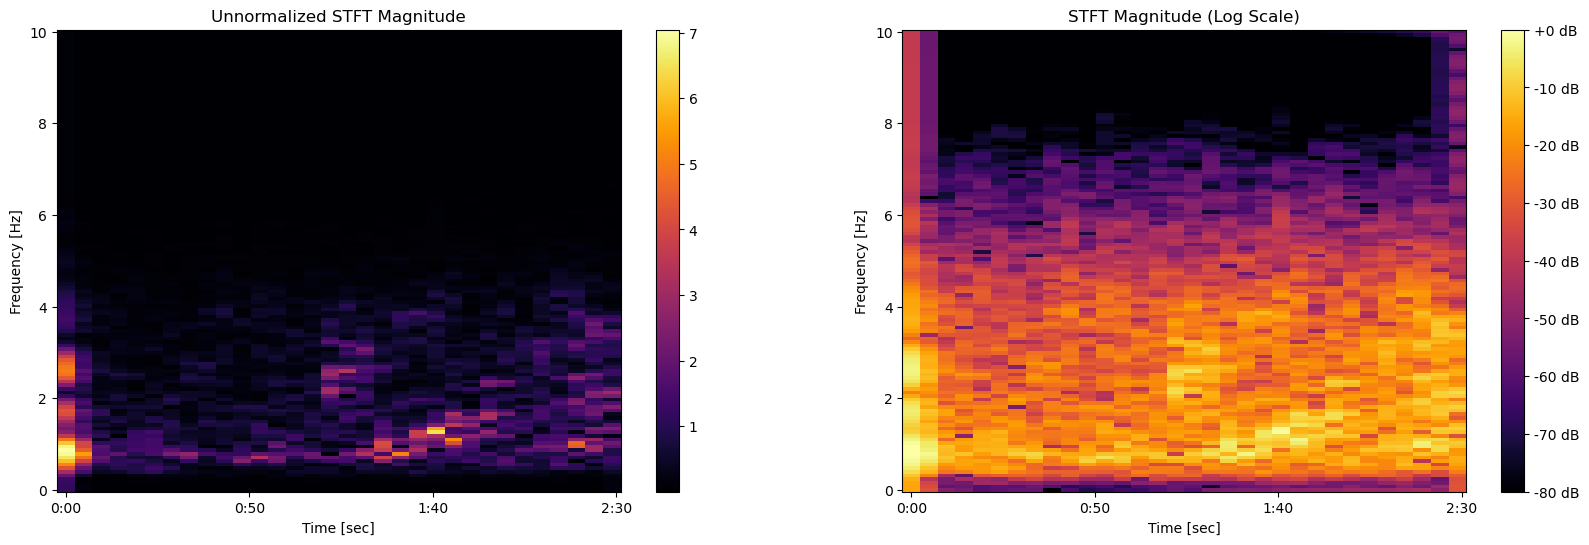

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/BEST_BEAM_TRAIN_TEST_CSV/2018-11-27_13-05-01.csv')
signal = df['beam [Pa]'].values  # Extract only the signal values
normalized_signal = librosa.util.normalize(signal)

# Define STFT parameters
n_fft = 254
hop_length = 96

# Define your signal's sample rate
sample_rate = 20

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(normalized_signal, n_fft=n_fft, hop_length=hop_length)

# Convert amplitude to dB for the normalized plot
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot the unnormalized STFT magnitude
img1 = librosa.display.specshow(np.abs(D), sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='inferno', ax=ax[0])
ax[0].set_title('Unnormalized STFT Magnitude')
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_ylim(0.7, 4)
fig.colorbar(img1, ax=ax[0])

# Plot the STFT magnitude with log scale normalization
img2 = librosa.display.specshow(D_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='inferno', ax=ax[1])
ax[1].set_title('STFT Magnitude (Log Scale)')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_ylim(0.7, 4)
fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')

plt.show()


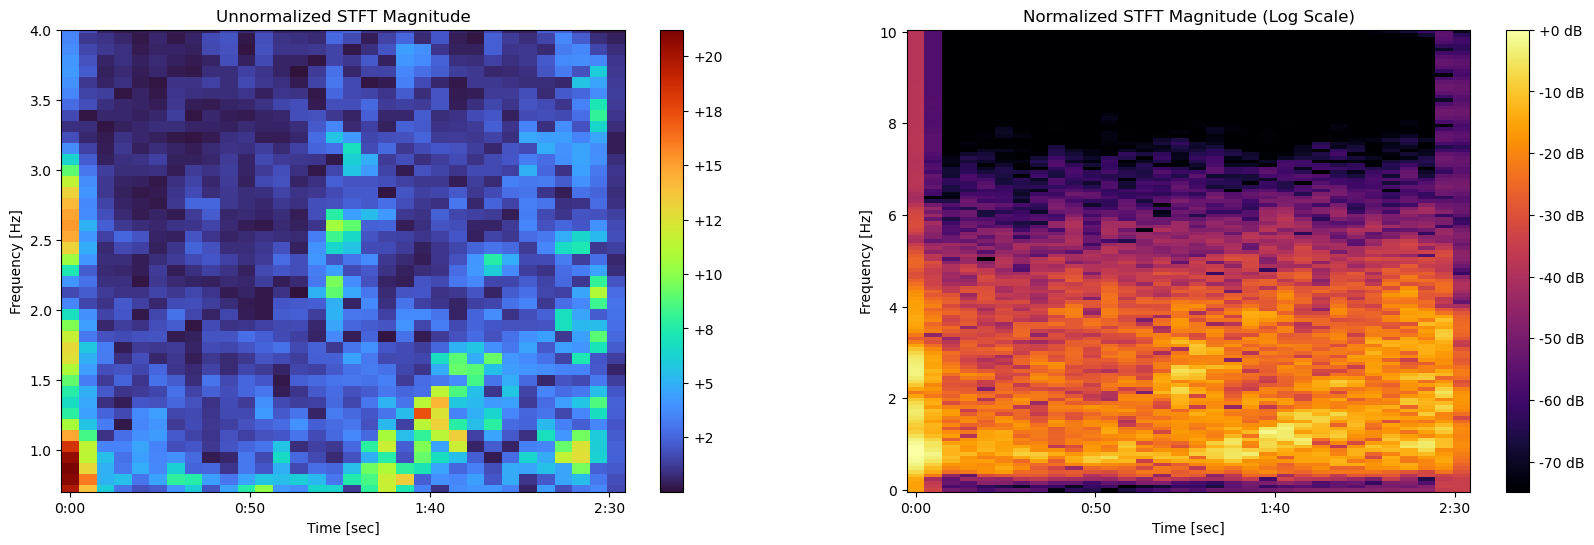

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import librosa.display

# Load your data
df = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/raw/BEST_BEAM_TRAIN_TEST_CSV/2018-11-27_13-05-01.csv')
signal = df['beam [Pa]'].values  # Extract only the signal values
normalized_signal = librosa.util.normalize(signal)

# Define STFT parameters
n_fft = 254
hop_length = 98

# Define your signal's sample rate
sample_rate = 20

# Calculate the Short-Time Fourier Transform (STFT) using SciPy
frequencies, times, Zxx = scipy.signal.stft(signal, fs=sample_rate, nperseg=n_fft, noverlap=n_fft - hop_length)
_, _, Zxx_normalized = scipy.signal.stft(normalized_signal, fs=sample_rate, nperseg=n_fft, noverlap=n_fft - hop_length)

# Convert amplitude to dB for the normalized plot
Zxx_normalized_db = librosa.amplitude_to_db(np.abs(Zxx_normalized), ref=np.max)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot the unnormalized STFT magnitude
img1 = librosa.display.specshow(np.abs(Zxx), sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='turbo', ax=ax[0])
ax[0].set_title('Unnormalized STFT Magnitude')
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_ylim(0.7, 4)
fig.colorbar(img1, ax=ax[0], format='%+2.0f')  # Add colorbar to the first plot

# Plot the normalized STFT magnitude with log scale normalization
img2 = librosa.display.specshow(Zxx_normalized_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='inferno', ax=ax[1])
ax[1].set_title('Normalized STFT Magnitude (Log Scale)')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Frequency [Hz]')

fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')  # Add colorbar to the second plot

plt.show()


In [26]:
import pandas as pd
import os
import glob

# Define the folder path that contains your CSV files
folder_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/TRAINTEST'

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# List to hold dataframes
dfs = []

# Loop over the list of csv files
for file in csv_files:
    # Read the csv file
    df = pd.read_csv(file)
    
    # Try to parse the start_time column as datetime and set as index, handling variations
    try:
        df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S.%f%z')
    except ValueError:
        df['start_time'] = pd.to_datetime(df['start_time'], infer_datetime_format=True)
    
    df = df.set_index('start_time')
    
    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs)

# Sort by index (start_time)
combined_df = combined_df.sort_index()

# Optionally, you can save the combined dataframe to a new csv file
combined_df.to_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/NORMALIZED_DATETIME.csv')


/tmp/ipykernel_455993/619761024.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['start_time'] = pd.to_datetime(df['start_time'], infer_datetime_format=True)
/tmp/ipykernel_455993/619761024.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['start_time'] = pd.to_datetime(df['start_time'], infer_datetime_format=True)
/tmp/ipykernel_455993/619761024.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-cons

ValueError: time data "2018-08-04 15:14:12.600000+00:00" doesn't match format "    %Y-%m-%d %H:%M:%S.%f%z", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/processed2_stft/VALID_non_overlap_datetime.csv')

# Convert the "start_time" column to a numpy array of UTC datetime objects
start_time_array = pd.to_datetime(df['start_time']).to_numpy()
print(start_time_array)

# Save the numpy array as a .npy file
np.save('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/processed2_stft/VALID_Non_Overlap.npy', start_time_array)